# Detecting signs of depression in Social Media

## About Data Set and depression

This project is based on data set created by: 
S Kayalvizhi and D Thenmozhi in 2022. Paper: "Data set creation and empirical analysis for detecting signs of depression from social media postings."
Data set was collected from Reddit archives of subreddits groups like: Mental Health, depression, loneliness, stress, anxiety. Data were pre-processed by removing the non-ASCII characters and emoticons to get a clean data set.  The collected postings data were annotated by two domain experts into three labels: “Not depressed, Moderate and Severe".

“Not Depressed" was annotade when data reflect one of the following mannerism:
- If the statements have only one or two lines about irrelevant topics. 
- If the statements reflect momentary feelings of present situation.
- If the statements are about asking questions about any or medication 
- If the statement is about ask/seek help for friend’s difficulties.

“Moderately depressed" was annotade when data falls under these conditions:
- If the statements reflect change in feelings (feeling low for some time and feeling better for some time). 
- If the statement shows that they aren’t feeling completely immersed in any situations
- If the statements show that they have hope for life.

“Severely depressed" was annotade when data have one of the following scenarios:
- If the statements express more than one disorder conditions. 
- If the statements explain about history of suicide attempts.

Because deppression can be diagnosed only by clinician expert using questionaries, clinical interwiev, patient observation and other technics, this annotation as depressed and moderately depressed cannot be treated as diagnosis. It is just assumption that user has signs of depression based on his/her declaration. 

**So what added value could be for such project?**
In my opinion value could be sygnificant:
Machine learning model could very fast detect sighns which looks like depression and could target such user with some information: for example sending them information about local clinicians, sending information about free help, invite to some neerest places for diagnosis, propose conversation with dedicated chatbot or specialist. 
Depression is higly corellated with suicidality and it could be far-fetched assumption but it can save someones live .

Let's start with importing all needed libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize.casual import casual_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Data preparation

Data set was stored in 3 files: train, dev and test. Test data did not have labels (because it was competition data to see competitors scores) so train and dev was concatenated to have one data set.
Let's see the data.

In [2]:
df1 = pd.read_csv('train.tsv', sep='\t')
df2 = pd.read_csv('dev.tsv', sep='\t') 

In [3]:
df1.head()

,PID,Text_data,Label
0,train_pid_1,Waiting for my mind to have a breakdown once t...,moderate
1,train_pid_2,My new years resolution : I'm gonna get my ass...,moderate
2,train_pid_3,New year : Somone else Feeling like 2020 will ...,moderate
3,train_pid_4,"My story I guess : Hi, Im from Germany and my ...",moderate
4,train_pid_5,Sat in the dark and cried myself going into th...,moderate


In [4]:
df2.head()

,PID,Text data,Label
0,dev_pid_1,"I enjoyed today, and I still am! Tomorrows dep...",moderate
1,dev_pid_2,I sorta tried to kill myself : I had a total b...,moderate
2,dev_pid_3,Best suicide method? : I like it quick and eas...,moderate
3,dev_pid_4,a story : I remember the time I'd get on my 3D...,moderate
4,dev_pid_5,The world only cares about beautiful people : ...,moderate


We have different labels name and column PID is not necessary.

In [5]:
df2.rename({'Text data': 'Text_data'}, inplace=True, axis='columns')
df = pd.concat([df1, df2], ignore_index=True)
df.drop(["PID"], axis=1, inplace=True)
df.head()

,Text_data,Label
0,Waiting for my mind to have a breakdown once t...,moderate
1,My new years resolution : I'm gonna get my ass...,moderate
2,New year : Somone else Feeling like 2020 will ...,moderate
3,"My story I guess : Hi, Im from Germany and my ...",moderate
4,Sat in the dark and cried myself going into th...,moderate


In [6]:
df.shape

(13387, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13387 entries, 0 to 13386
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text_data  13387 non-null  object
 1   Label      13387 non-null  object
dtypes: object(2)
memory usage: 209.3+ KB


We can see we have 13387 rows and 2 columns. All data are in string format (object dtype). 
Let's see if we have duplicates.

In [8]:
df.drop_duplicates(inplace=True, ignore_index=True)

In [9]:
df.shape

(7115, 2)

There are a lot of duplcates, all were deleted.

# Data exploration

Let's see how target is distributed in data.

In [10]:
df['Label'].value_counts()

moderate          3611
not depression    2742
severe             762
Name: Label, dtype: int64

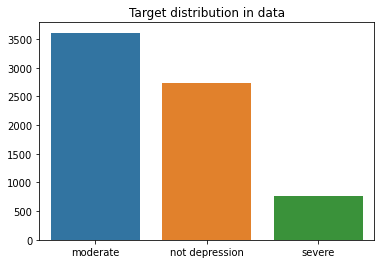

In [11]:
sns.barplot(x=df['Label'].value_counts().index, y=df['Label'].value_counts().values)
plt.title("Target distribution in data", fontsize=12)
plt.show()

Most rows are labeled as moderate depression(3611), on second place we have not depresion (2746) and the fewest: severe depression (762).
For this classification case we need to have labels 0, 1 and 2, because for some classifiers it is mandatory. To simulate intensivity of depression target will be changed as below:

In [12]:
df["Label"].replace({"not depression": 0, "moderate": 1, "severe": 2}, inplace=True)

Let's check what words are mostly used for severe, moderately and not depressed users. Will choose casual tokenizer which is dedicated for social media. We will also add lematizaion (it will find base of the word, not removing/replacing word suffixes as in stemming) and delete english stop words. 

In [13]:
text_data_severe = df[df["Label"]==2]["Text_data"]
text_data_moderate = df[df["Label"]==1]["Text_data"]
text_data_not_depressed = df[df["Label"]==0]["Text_data"]

In [14]:
text_data_severe

599     Falling in love with depression and OCD. Anoth...
608     I’m so empty : I wake up to the malevolent gla...
609     I can't kill myself because of my parents : I ...
616     Feeling numb. : Okay this is my first post, ap...
639     I can't do this anymore. : I have several ment...
                              ...                        
7110    Aren’t we all just tired? : I’ve been depresse...
7111    NEED HELP COPING : I had my life pretty much f...
7112    Qutting Zoloft Cold Turkey : I was on 75 mg se...
7113    Crying : I’m coming off my antidepressants and...
7114    Seeking for advice on how to overcome and deal...
Name: Text_data, Length: 762, dtype: object

In [15]:
text_data_moderate

0       Waiting for my mind to have a breakdown once t...
1       My new years resolution : I'm gonna get my ass...
2       New year : Somone else Feeling like 2020 will ...
3       My story I guess : Hi, Im from Germany and my ...
4       Sat in the dark and cried myself going into th...
                              ...                        
4981    Lockdown has made so depressed : Help me, I fe...
4982    Am i just being dramatic? Do i really feel thi...
4983    Just another day of dealing with Depression. J...
4984    I just want to vent a bit, nothing special ple...
4985    Shit fucking day : Having the shittest day, do...
Name: Text_data, Length: 3611, dtype: object

In [16]:
text_data_not_depressed

597     i lost my virginity and 5 mins later my gf sai...
600     This is a question that gives me SO MUCH anxie...
601     Insecurities, fuck em. : I constantly feel lik...
602     i came here in reddit to be entertained. now i...
603     Empty : I wanted to have friends. People to sh...
                              ...                        
6770    I never feel like I'm enough and I can't get m...
6771    Just want to talk to someone real : I find mys...
6772    on the verge of tears but no real reason to cr...
6773    admitting to myself to the hospital tomorrow :...
6774    Does anyone else hate it when people say "You ...
Name: Text_data, Length: 2742, dtype: object

I will prepare function for finding most common words from all type users.

In [17]:
stop_words = stopwords.words('english') 
wl = WordNetLemmatizer()

def count_words(data):
    '''
    Return counted words from data using stop words, casual tokenizer and lematizer
    
    :param data: DataFrame with data
    
    :return: list with counted words
    '''
    
    casual_tekenizer_lists = [casual_tokenize(post) for post in data]
    casual_tekenizer = list(np.concatenate(casual_tekenizer_lists).flat)
    without_stop_words = [word for word in casual_tekenizer if word.lower() not in stop_words and word.isalpha()]
    after_lem = [wl.lemmatize(word) for word in without_stop_words]
    return Counter(after_lem)

Let's check what are mostly used top 20 words in group with severe, moderate and without depression.

In [18]:
count_severe_words = count_words(text_data_severe)
top20_severe_words = count_severe_words.most_common(20)
print(top20_severe_words)

[('like', 1213), ('feel', 1200), ('want', 1073), ('get', 832), ('know', 820), ('time', 736), ('life', 704), ('year', 699), ('depression', 682), ('day', 622), ('even', 565), ('really', 555), ('thing', 526), ('friend', 518), ('go', 512), ('people', 503), ('would', 474), ('help', 443), ('one', 440), ('die', 433)]


In [19]:
count_moderate_words = count_words(text_data_moderate)
top20_moderate_words = count_moderate_words.most_common(20)
print(top20_moderate_words)

[('like', 4745), ('feel', 4719), ('know', 3190), ('want', 3122), ('life', 2802), ('get', 2794), ('time', 2695), ('friend', 2227), ('even', 2200), ('year', 2160), ('thing', 2029), ('really', 2017), ('people', 2009), ('day', 1845), ('one', 1837), ('go', 1682), ('would', 1608), ('make', 1555), ('depression', 1516), ('think', 1492)]


In [20]:
count_not_depressed_words = count_words(text_data_not_depressed)
top20_not_depressed_words = count_not_depressed_words.most_common(20)
print(top20_not_depressed_words)

[('like', 2141), ('feel', 2007), ('know', 1504), ('want', 1342), ('get', 1244), ('life', 1215), ('time', 1167), ('friend', 1066), ('people', 1057), ('really', 942), ('thing', 939), ('one', 937), ('even', 933), ('year', 891), ('day', 889), ('make', 778), ('go', 721), ('would', 711), ('think', 708), ('going', 680)]


We can see that many words are the same in all groups: like, feel, know, want etc. We would like to see what words are specific for each group. But before we do this, let's visiualize how top 20 words are distributed on one group. For example for severly depressed.

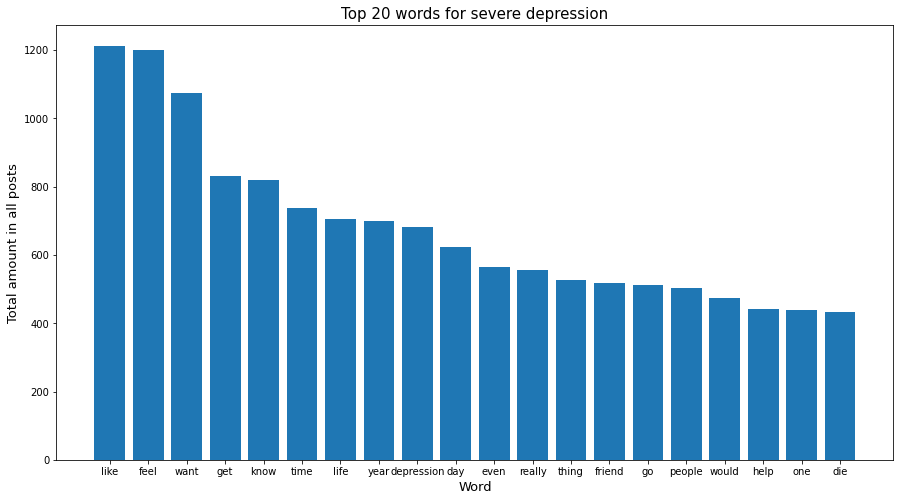

In [21]:
x_list_s20 = [x[0] for x in top20_severe_words]
y_list_s20 = [x[1] for x in top20_severe_words]

plt.figure(figsize=(15, 8))
plt.title("Top 20 words for severe depression", fontsize=15)
plt.xlabel("Word", fontsize=13)
plt.ylabel("Total amount in all posts", fontsize=13)
plt.bar(x=x_list_s20, height=y_list_s20)
plt.show()

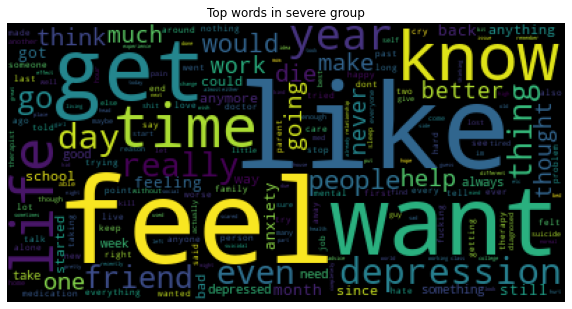

In [22]:
wc = WordCloud()
wc.generate_from_frequencies(count_severe_words)
plt.figure(figsize=(10, 8))
plt.title("Top words in severe group", fontsize=12)
plt.imshow(wc)
plt.axis('off')
plt.show()

We can see that three most popular words are: like, feel and want.
<br>Now, let's check what words are used in all groups and what only in one of them (limited to 50 words).

In [23]:
top50_severe_words = count_severe_words.most_common(50)
top50_moderate_words = count_moderate_words.most_common(50)
top50_not_depressed_words = count_not_depressed_words.most_common(50)

x_list_s50 = [x[0] for x in top50_severe_words]
x_list_m50 = [x[0] for x in top50_moderate_words]
x_list_n50 = [x[0] for x in top50_not_depressed_words]

In [24]:
words_in_all_groups = [x for x in x_list_s50 if x in x_list_m50 and x in x_list_n50]
print(f"List of words which are present in all groups (limited to top 50 words):\n{words_in_all_groups}")

List of words which are present in all groups (limited to top 50 words):
['like', 'feel', 'want', 'get', 'know', 'time', 'life', 'year', 'depression', 'day', 'even', 'really', 'thing', 'friend', 'go', 'people', 'would', 'help', 'one', 'think', 'going', 'make', 'much', 'thought', 'better', 'never', 'work', 'feeling', 'back', 'got', 'still', 'anything', 'school', 'way', 'anymore', 'could', 'something', 'good', 'always', 'everything']


In [25]:
words_only_in_severe50 = [x for x in x_list_s50 if x not in x_list_m50 and x not in x_list_n50]
print(f"List of words which are present only in severe group (limited to top 50 words):\n{words_only_in_severe50}")

List of words which are present only in severe group (limited to top 50 words):
['die', 'anxiety', 'month', 'since', 'bad', 'started', 'week', 'take']


In [26]:
words_only_in_moderate50 = [x for x in x_list_m50 if x not in x_list_s50 and x not in x_list_n50]
print(f"List of words which are present only in moderate group (limited to top 50 words):\n{words_only_in_moderate50}")

List of words which are present only in moderate group (limited to top 50 words):
['hate', 'nothing', 'family', 'happy', 'fucking']


When we limited to 50 most common words it looks very interesting: only people with severe depression use words "die", "anxiety" etc, and for moderate depression: 'hate', 'nothing' etc. Let's see what it will look like when we expand it to 100 words.

In [27]:
top100_severe_words = count_severe_words.most_common(100)
top100_moderate_words = count_moderate_words.most_common(100)
top100_not_depressed_words = count_not_depressed_words.most_common(100)

x_list_s100 = [x[0] for x in top100_severe_words]
x_list_m100 = [x[0] for x in top100_moderate_words]
x_list_n100 = [x[0] for x in top100_not_depressed_words]

In [28]:
words_only_in_severe100 = [x for x in x_list_s100 if x not in x_list_m100 and x not in x_list_n100]
print(f"List of words which are present only in severe group (limited to top 100 words):\n{words_only_in_severe100}")

List of words which are present only in severe group (limited to top 100 words):
['anxiety', 'medication', 'wanted', 'ago', 'therapy', 'past', 'stop', 'problem', 'went', 'mental', 'two']


In [29]:
words_only_in_moderate100 = [x for x in x_list_m100 if x not in x_list_s100 and x not in x_list_n100]
print(f"List of words which are present only in moderate group (limited to top 100 words):\n{words_only_in_moderate100}")

List of words which are present only in moderate group (limited to top 100 words):
['im', 'tired']


Now it is more interesting. It looks like people only with moderate depression are writing about being tired on reddit(when we limit to 100 most common words).

# Baseline

Now, we will try to find best baseline vectorizer. At first let's split data to train and test

In [30]:
X = df['Text_data']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify = y)

### CountVectorizer vs TFIDFVectorizer

At first we will try to find baseline vectorizer. Let's see how f1 score (macro anf weighted) looks like for different vectorizes with different classification models.

In [31]:
names = ['LogRegr', 'SupVecM', 'MulNomB', 'DecTree', 'RandFor', 'XGBoost']

models = [LogisticRegression(max_iter=10000),
              SVC(),
              MultinomialNB(),
              DecisionTreeClassifier(),
              RandomForestClassifier(),
              XGBClassifier()]


def f1_macro_avg(model, X, y):
    y_pred = model.predict(X)
    return f1_score(y_true=y, y_pred=y_pred, average='macro')  


def f1_weighted_avg(model, X, y):
    y_pred = model.predict(X)
    return f1_score(y_true=y, y_pred=y_pred, average='weighted')


def get_performance(model, X, y):
    return f"F1 macro avg: {f1_macro_avg(model, X, y): .2f}, F1 weighted avg: {f1_weighted_avg(model, X, y): .2f} "


def basic_performance(vectorizer, names=names, models=models):

    basic_performance = {}

    for model, name in zip(models, names):
        pipe = Pipeline([
        ('vct', vectorizer),
        (name ,model)
        ])
        pipe.fit(X_train, y_train)
        performance = get_performance(pipe, X_test, y_test)
        basic_performance[name] = performance
    
    return basic_performance

In [32]:
basic_perf_countvectorizer = basic_performance(vectorizer=CountVectorizer())

In [33]:
basic_perf_countvectorizer

{'LogRegr': 'F1 macro avg:  0.50, F1 weighted avg:  0.55 ',
 'SupVecM': 'F1 macro avg:  0.42, F1 weighted avg:  0.56 ',
 'MulNomB': 'F1 macro avg:  0.49, F1 weighted avg:  0.56 ',
 'DecTree': 'F1 macro avg:  0.43, F1 weighted avg:  0.50 ',
 'RandFor': 'F1 macro avg:  0.41, F1 weighted avg:  0.55 ',
 'XGBoost': 'F1 macro avg:  0.49, F1 weighted avg:  0.58 '}

In [34]:
basic_perf_tfidfvectorizer = basic_performance(vectorizer=TfidfVectorizer())

In [35]:
basic_perf_tfidfvectorizer

{'LogRegr': 'F1 macro avg:  0.51, F1 weighted avg:  0.59 ',
 'SupVecM': 'F1 macro avg:  0.48, F1 weighted avg:  0.59 ',
 'MulNomB': 'F1 macro avg:  0.27, F1 weighted avg:  0.40 ',
 'DecTree': 'F1 macro avg:  0.43, F1 weighted avg:  0.50 ',
 'RandFor': 'F1 macro avg:  0.41, F1 weighted avg:  0.56 ',
 'XGBoost': 'F1 macro avg:  0.52, F1 weighted avg:  0.60 '}

We can see that F1 scores for countvectorizer are relatively constans in small range: 
<br>macro:&emsp;&emsp;0.41 - 0.50 
<br>weighted: 0.51 - 0.58
<br>
<br>In TFIDFvectorizer F1 is in wider range but mostly higher than countvectorizer:
<br>macro:&emsp;&emsp;0.27 - 0.52
<br>weighted: 0.40 - 0.60
<br>
<br> Only MultiNomialNB has betther results in Countvectorizer than TFIDF, so for further hypertuning we will choose TFIDFvectorizer.
<br>Now let's try to find what is better for TFIDFvectorizer performance Stemming or Lematization.

### Stemming vs Lematization

For both normalizing methods we will delete stop words.

In [36]:
stop_w = set(stopwords.words('english'))

class LemmaTokenizer:
    
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        
    def __call__(self, doc):
        return [self.wnl.lemmatize(w) for w in casual_tokenize(doc) if w not in stop_w and w.isalnum()]


class StemTokenizer:
    
    def __init__(self):
        self.ps = PorterStemmer()

    def __call__(self, doc):
        return [self.ps.stem(w) for w in casual_tokenize(doc) if w not in stop_w and w.isalnum()]


def performance_with_text_normalization(tokenizer, names=names, models=models):

    basic_performance = {}

    for model, name in zip(models, names):
        pipe = Pipeline([
        ('vct', TfidfVectorizer(tokenizer=tokenizer)),
        (name ,model)
        ])
        pipe.fit(X_train, y_train)
        performance = get_performance(pipe, X_test, y_test)
        basic_performance[name] = performance
    
    return basic_performance

In [37]:
basic_lema_perf = performance_with_text_normalization(LemmaTokenizer())

In [38]:
basic_lema_perf

{'LogRegr': 'F1 macro avg:  0.51, F1 weighted avg:  0.58 ',
 'SupVecM': 'F1 macro avg:  0.48, F1 weighted avg:  0.58 ',
 'MulNomB': 'F1 macro avg:  0.28, F1 weighted avg:  0.41 ',
 'DecTree': 'F1 macro avg:  0.43, F1 weighted avg:  0.50 ',
 'RandFor': 'F1 macro avg:  0.42, F1 weighted avg:  0.56 ',
 'XGBoost': 'F1 macro avg:  0.52, F1 weighted avg:  0.59 '}

In [39]:
basic_stem_perf = performance_with_text_normalization(StemTokenizer())

In [40]:
basic_stem_perf

{'LogRegr': 'F1 macro avg:  0.51, F1 weighted avg:  0.59 ',
 'SupVecM': 'F1 macro avg:  0.49, F1 weighted avg:  0.58 ',
 'MulNomB': 'F1 macro avg:  0.29, F1 weighted avg:  0.42 ',
 'DecTree': 'F1 macro avg:  0.43, F1 weighted avg:  0.50 ',
 'RandFor': 'F1 macro avg:  0.41, F1 weighted avg:  0.55 ',
 'XGBoost': 'F1 macro avg:  0.49, F1 weighted avg:  0.58 '}

We can see that there is no big difference between Stemmer and Lematizer, so we will choose lemmatizer because stemmer is more agressiv. 
<br> We can also see that the best three classificators are: LogisticRegression, SupportVectorMachines and XGBoost.

Summarizing, for baseline we will have TFIDF vectorizer with casual tokenizer, Lematizator without english stop words.

# MODELING

Now, we are going to  look for best scores for three models: LogisticRegression, SupportVectorMachines and XGBoost. For every model we will have same steps as listed in below order:
- create pipeline
- define grip parameters for hypertuning
- perform gridsearch and find best parameters
- check scores for model baseli and with best parameters

Let's prepare functions for those steps:

In [41]:
def create_pipeline(model, name):
    '''
    Create pipeline for defined classifier
    
    :param model: classification model
    :param name (str): name for classification model
    
    :return: pipeline object
    '''

    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=LemmaTokenizer())),
        (name ,model)
        ])
    
    return pipe


def find_best_estimator(pipe, params, cv = 3, X_train = X_train, y_train = y_train):
    '''
    Perform GridSearchCV to optimaze hyperparameters. Print best parameters and return model.
 
    :param pipe: pipeline with classifier
    :param params (dict): parameters grid
    :param cv (int): number of folds in cross validation      
    :param X_train (np, df, list): traning data without label column
    :param y_train (np, df, list): only label column for training data
    
    :return: classification model with best parameters
    '''
    
    gs = GridSearchCV(estimator = pipe, 
                      param_grid = params, 
                      cv = cv, 
                      n_jobs = -1, 
                      verbose = 1,
                      scoring= 'f1_macro')
    gs.fit(X_train,y_train)
    print('Best parameters found: ')
    print(gs.best_params_)
    
    return gs.best_estimator_


def show_best_model_score(model, X_test = X_test, y_test = y_test):
    '''
    Print classification report.
 
    :param model: fitted model with best parameters   
    :param X_test (np, df, list): test data without label column
    :param y_test (np, df, list): only label column for test data

    '''
    
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred))

### LogisticRegression

In [42]:
log_reg_pipeline = create_pipeline(LogisticRegression(max_iter=10000), 'log_reg')

In [43]:
log_reg_param = {
 'tfidf__max_features':[1000, 2000],
 'tfidf__ngram_range': [(1, 1), (1, 2)],
 'log_reg__penalty': ['l1', 'l2'],
 'log_reg__solver': ['lbfgs', 'saga'],   
 'log_reg__C': [10, 1, 0.1]
}

In [44]:
best_log_reg = find_best_estimator(log_reg_pipeline, log_reg_param)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/opt/homebrew/Cellar/jupyterlab/3.3.2/libexec/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
36 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/jupyterlab/3.3.2/libexec/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Cellar/jupyterlab/3.3.2/libexec/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/homebrew/Cellar/jupyterlab/3.3.2/libexec/lib/python3

Best parameters found: 
{'log_reg__C': 1, 'log_reg__penalty': 'l1', 'log_reg__solver': 'saga', 'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 1)}


Score for Logistic Regresion baseline:

In [45]:
log_regr_baseline = create_pipeline(LogisticRegression(max_iter=10000), 'log_reg')
log_regr_baseline.fit(X_train,y_train)
show_best_model_score(log_regr_baseline)

              precision    recall  f1-score   support

           0       0.59      0.50      0.54       823
           1       0.60      0.76      0.67      1083
           2       0.73      0.20      0.31       229

    accuracy                           0.60      2135
   macro avg       0.64      0.49      0.51      2135
weighted avg       0.61      0.60      0.58      2135



Score for Logistic Regresion with best parameters:

In [46]:
show_best_model_score(best_log_reg)

              precision    recall  f1-score   support

           0       0.60      0.50      0.54       823
           1       0.60      0.75      0.67      1083
           2       0.65      0.24      0.35       229

    accuracy                           0.60      2135
   macro avg       0.62      0.50      0.52      2135
weighted avg       0.60      0.60      0.59      2135



Hypertuning for Logistic Regression did not help much.

In [47]:
# Rest of modeling is ongoing